# Import Libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import LinearSVC

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/03d_modeling_svm'

# Loading data & preprocessing

## Train data

In [4]:
path_to_ftir_train_data = './../data/processed_data/ftir_engineered_features_train.csv'

In [5]:
data_train = pd.read_csv(path_to_ftir_train_data, index_col=0)

# data_train.index = data.index.astype(str)

print(data_train.shape)
data_train.head(3)

(25, 81)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$,$(ΣI^{-1})_{n}$,$(ΣI^2)_{n}$,$(ΣI^{-2})_{n}$,$(ΣI^3)_{n}$,...,$(S_{1619}^{-5})_{n}$,$(I_{1720}^{-1})_{n}$,$(I_{1720}^2)_{n}$,$(I_{1720}^{-2})_{n}$,$(I_{1720}^3)_{n}$,$(I_{1720}^{-3})_{n}$,$(I_{1720}^4)_{n}$,$(I_{1720}^{-4})_{n}$,$(I_{1720}^5)_{n}$,$(I_{1720}^{-5})_{n}$,$(S_{1720}^{-1})_{n}$,$(S_{1720}^2)_{n}$,$(S_{1720}^{-2})_{n}$,$(S_{1720}^3)_{n}$,$(S_{1720}^{-3})_{n}$,$(S_{1720}^4)_{n}$,$(S_{1720}^{-4})_{n}$,$(S_{1720}^5)_{n}$,$(S_{1720}^{-5})_{n}$,$(ln|ΣI|)_{n}$,$(ln|ΣS|)_{n}$,$(ln|I_{1619}|)_{n}$,$(ln|S_{1619}|)_{n}$,$(ln|I_{1720}|)_{n}$,$(ln|S_{1720}|)_{n}$
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158,0.024117,4.708838,0.783430,4.390159,0.094618,195.247462,32.484193,182.033770,3.923244,0.166374,0.932323,0.020094,5.603765,0.120774,0.021552,0.343041,8.497808,0.117677,24.771960,...,0.001402,1.506006,0.440906,2.268055,0.292765,3.415706,0.194398,5.144075,0.129082,7.747011,0.032458,949.204210,0.001054,29244.182358,0.000034,900988.631502,0.000001,2.775870e+07,3.602474e-08,1.069904,4.794731,-0.479537,1.313977,-0.409461,3.427812
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930,0.043276,5.876673,0.326323,8.177088,4.049420,135.794536,7.540462,188.951098,93.571485,0.055528,1.391448,0.689067,25.058291,12.409251,0.495215,0.253820,15.522024,0.064425,61.153670,...,0.000004,2.075508,0.232141,4.307735,0.111848,8.940741,0.053889,18.556584,0.025964,38.514347,1.027824,0.946592,1.056421,0.920967,1.085815,0.896036,1.116026,8.717801e-01,1.147078e+00,1.371130,4.511282,-0.399861,2.490999,-0.730206,-0.027444
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582,0.033361,7.522086,0.332542,8.061920,0.611503,225.472431,9.967844,241.653809,18.329623,0.044209,1.071767,0.081294,24.243337,1.838875,0.075851,0.349308,8.195624,0.122016,23.462432,...,0.000021,2.816096,0.126097,7.930397,0.044777,22.332761,0.015900,62.891200,0.005646,177.107662,0.213603,21.917211,0.045626,102.607222,0.009746,480.364133,0.002082,2.248864e+03,4.446689e-04,1.051800,4.452155,-0.966043,2.152790,-1.035352,1.543636


## Samples description

In [6]:
path_to_samples_description = './../data/preprocessed_data/ftir_description.csv'

In [7]:
samples_description = pd.read_csv(path_to_samples_description, index_col=0)

# samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Dataset wrangling

## Correction of column `Type`

In [8]:
# type_dict = {
#     '$rGO$': '$вОГ$',
#     '$GO$': '$ОГ$',
#     '$GO_{d}$': '$ОГ_{диализ}$',
# }

# samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

# print(samples_description.shape)
# samples_description.head(3)

## Selecting *Train* part of `samples_description`

In [9]:
samples_description = samples_description.loc[samples_description['Label'] == 'Train']

print(samples_description.shape)
samples_description.head(3)

(25, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


## Selecting features from `data_train`

In [10]:
factors_top1 = [
    r'$(\frac{S_{1619}}{I_{1720}})_{n}$',
    r'$(ln|I_{1720}|)_{n}$'
]

factors_top2 = [
    r'$S_{1619, n}$',
    r'$(\frac{ΣI}{I_{1720}})_{n}$'
]

factors_top3 = [
    r'$(\frac{ΣS}{I_{1720}})_{n}$',
    r'$(\frac{S_{1619}}{I_{1720}})_{n}$'
]

factors_pairs = list(set(factors_top1 + factors_top2 + factors_top3))

In [11]:
data_train = data_train[factors_pairs]

print(data_train.shape)
data_train.head(3)

(25, 5)


,$(\frac{ΣI}{I_{1720}})_{n}$,$(ln|I_{1720}|)_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,"$S_{1619, n}$",$(\frac{S_{1619}}{I_{1720}})_{n}$
1,4.390159,-0.409461,182.033770,3.720943,5.603765
2,8.177088,-0.730206,188.951098,12.073326,25.058291
3,8.061920,-1.035352,241.653809,8.608846,24.243337


In [12]:
data = (
    data_train
    .merge(
        right=samples_description,
        how='inner',
        left_index=True,
        right_index=True
    )
)

print(data.shape)
data.head(3)

(25, 9)


,$(\frac{ΣI}{I_{1720}})_{n}$,$(ln|I_{1720}|)_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,"$S_{1619, n}$",$(\frac{S_{1619}}{I_{1720}})_{n}$,Description,Type,Class,Label
1,4.390159,-0.409461,182.033770,3.720943,5.603765,"MFGO, разб. 1:20",$GO$,1,Train
2,8.177088,-0.730206,188.951098,12.073326,25.058291,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,8.061920,-1.035352,241.653809,8.608846,24.243337,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Modeling (*SVM*-classifier)

## Variables wrangling

In [13]:
class_type_dict = {
    1: '$GO$',
    0: '$rGO$',
    2: '$GO_{d}$'
}

class_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

fontsize = 22

titles_lst = ['A', 'B', 'C']

factors_pairs = [factors_top1, factors_top2, factors_top3]

## Model fitting & visualization

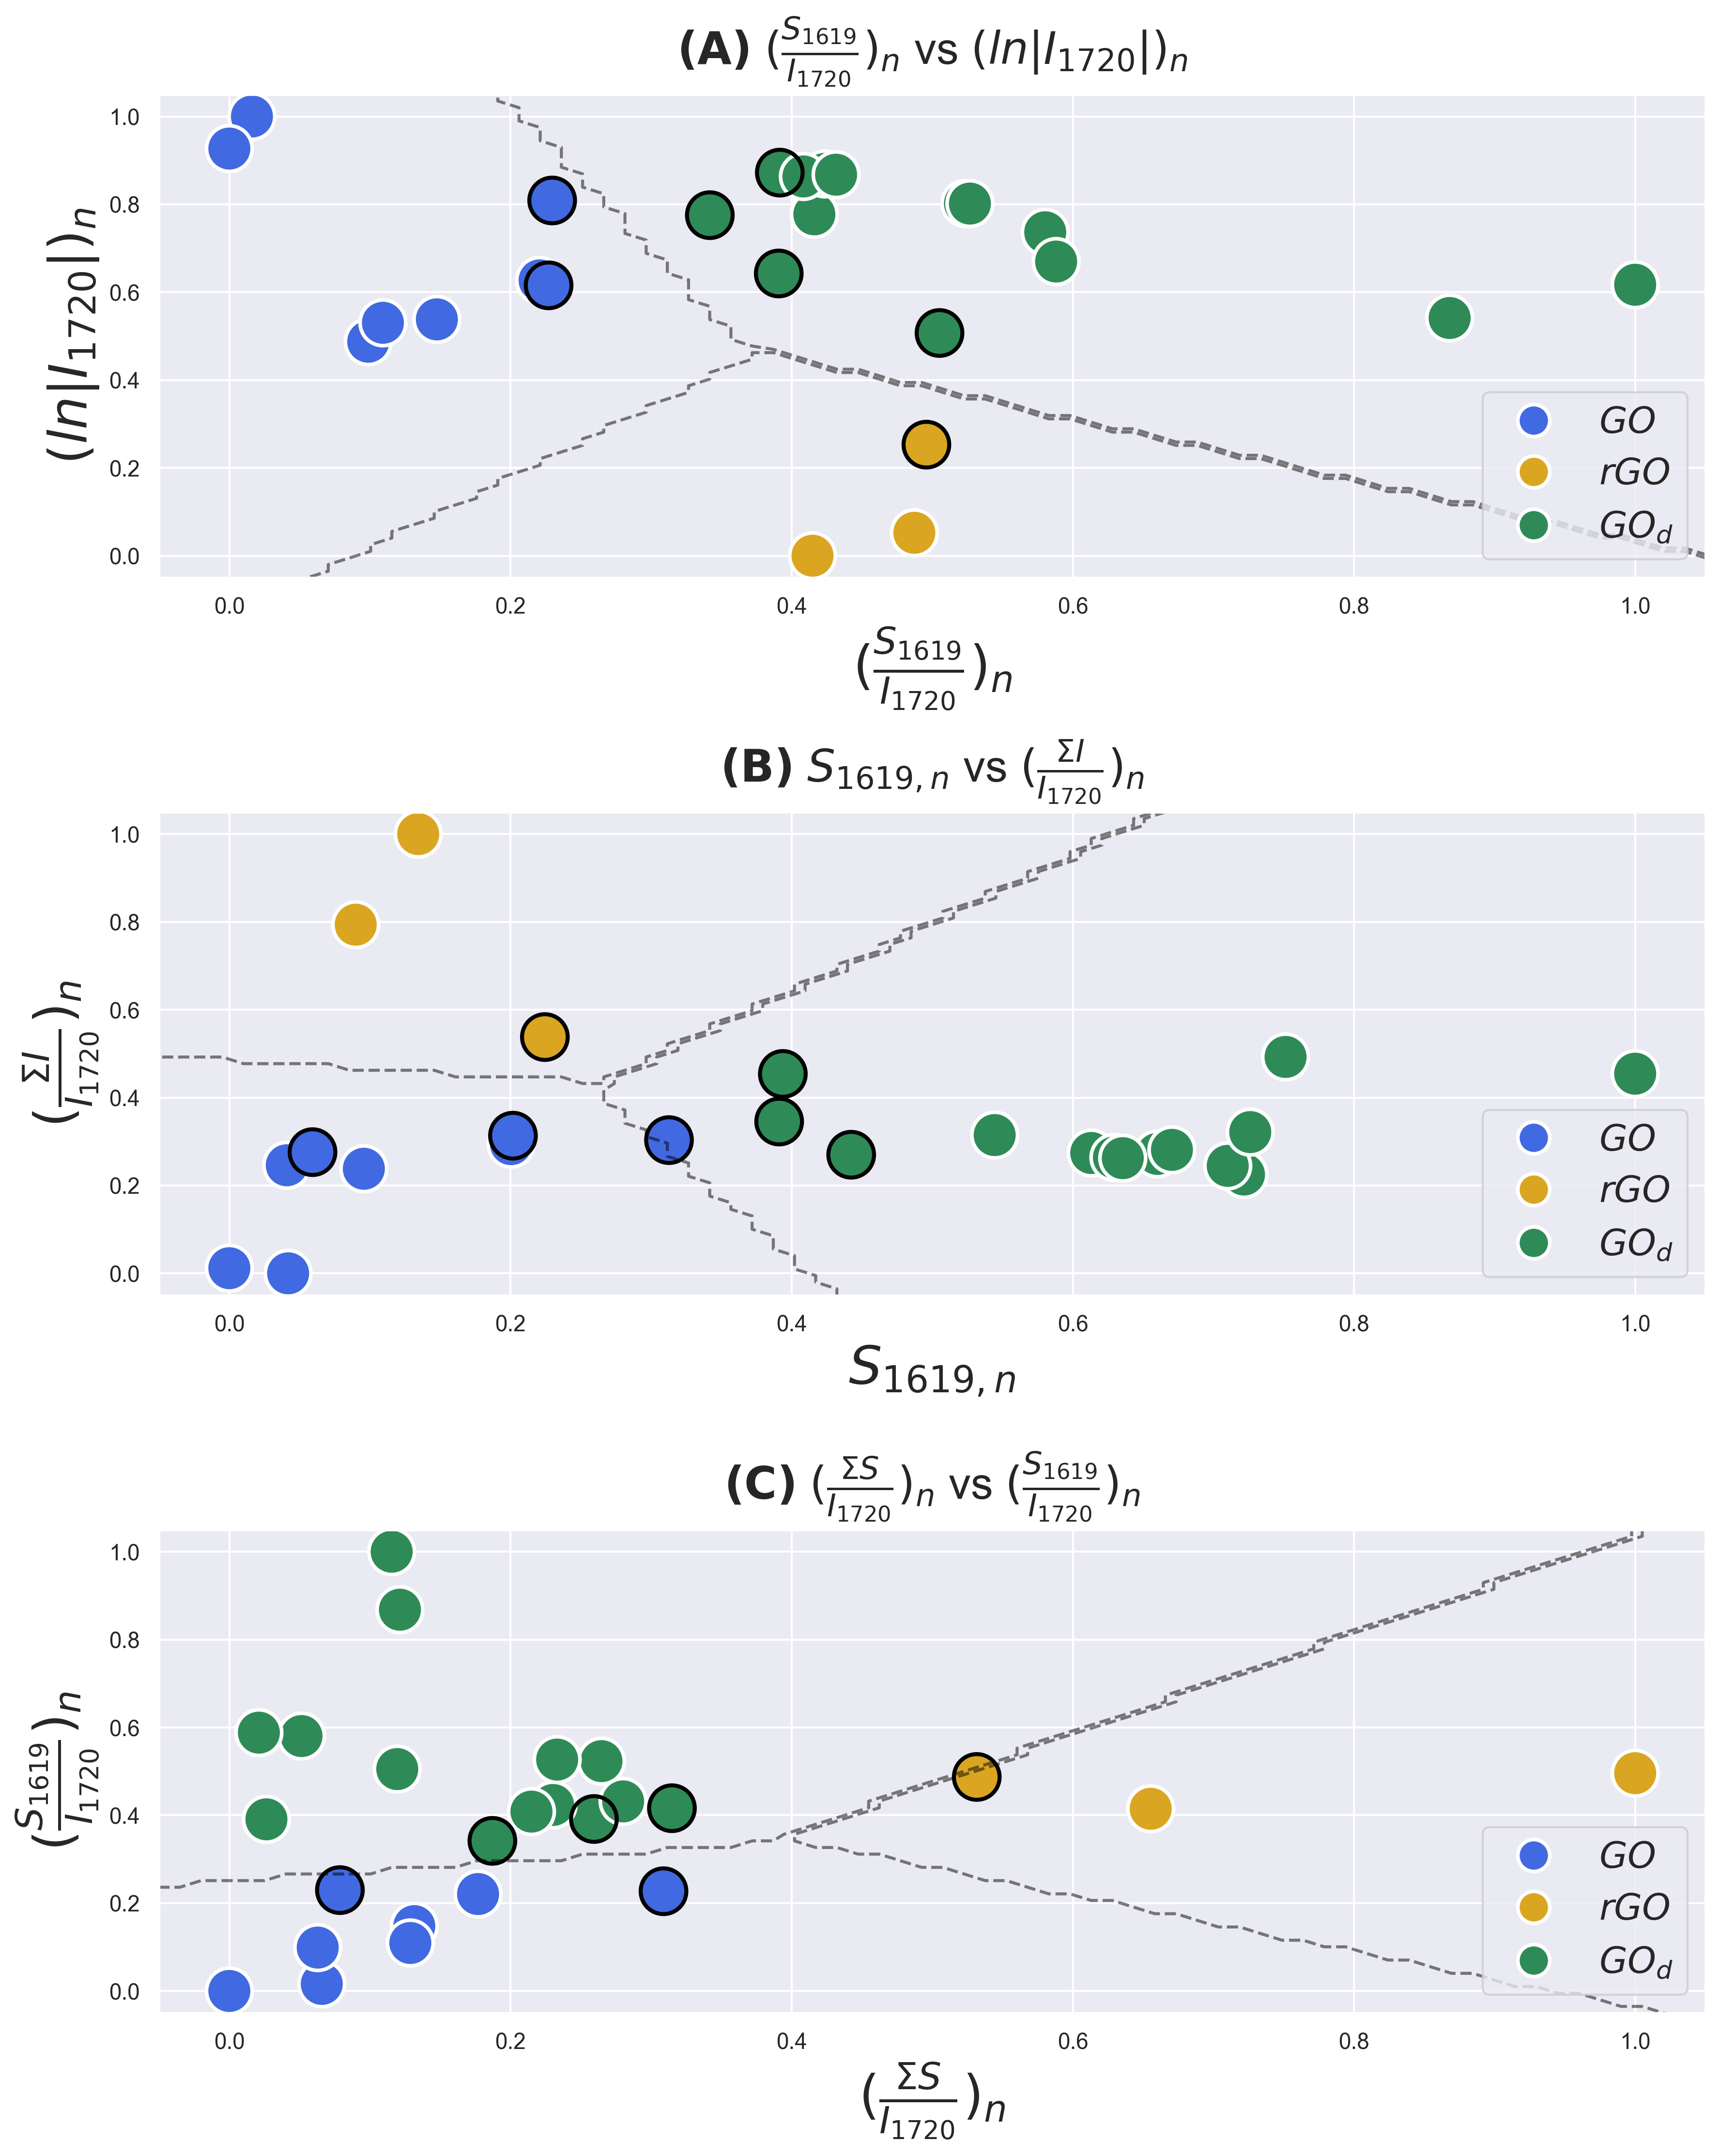

In [14]:
sns.set_theme()

nrows = 3
ncols = 1

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 15), dpi=300)

for i, (feature_1, feature_2) in enumerate(factors_pairs):
    ax = axes[i]

    X = data[[feature_1, feature_2]].values
    y = data['Class'].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    clf = LinearSVC(C=100, penalty="l2", loss="hinge", random_state=42, dual=True)
    clf.fit(X_scaled, y)

    decision_function = clf.decision_function(X_scaled)

    y_pred = clf.predict(X_scaled)
    accuracy = accuracy_score(y, y_pred)

    if decision_function.ndim > 1:
        support_vector_mask = np.any(np.abs(decision_function) <= 1, axis=1)
    else:
        support_vector_mask = np.abs(decision_function) <= 1

    support_vector_indices = np.where(support_vector_mask)[0]
    support_vectors = X_scaled[support_vector_indices]

    hue_labels = np.vectorize(class_type_dict.get)(y)  
    palette = {class_type_dict[k]: class_color_dict[class_type_dict[k]] for k in class_type_dict.keys()}

    sns.scatterplot(
        x=X_scaled[:, 0],
        y=X_scaled[:, 1],
        hue=hue_labels,
        palette=palette,
        s=512,
        ax=ax
    )

    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_scaled,
        ax=ax,
        grid_resolution=200,
        plot_method="contour",
        colors="black",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=['--', '--', '--']
    )

    ax.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=512,
        linewidth=2,
        facecolors="none",
        edgecolors="black",
    )

    title_text = rf"$\mathbf{{({titles_lst[i]})}}$ {feature_1} vs {feature_2}"
    ax.set_title(title_text, fontsize=fontsize, pad=15)

    ax.set_xlabel(feature_1, fontsize=fontsize+4)
    ax.set_ylabel(feature_2, fontsize=fontsize+4)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

    ax.legend(loc='lower right', fontsize=fontsize-4, markerscale=0.7)

plt.tight_layout()

plt.savefig(f'{path_to_save}/svm_scterrplots_3_subplots.png', dpi=600)

plt.show()
